In [4]:
# 时序差分算法中的SARSA算法的实现
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [5]:
# 定义漫步悬崖情景，此时不提供环境的状态转移概率和奖励函数了

class CliffWalkingEnv:
    def __init__(self,ncol,nrow):
        self.ncol = ncol
        self.nrow = nrow

        # agent当前位置信息，也就是当前状态
        self.col = 0
        self.row = self.nrow-1

        self.actions = [[0, -1], [0, 1], [-1, 0], [1, 0]] # 上下左右移动
    
    def step(self,action):
        '''
        当agent 通过action和环境交互的时候，获得的奖励，以及对应的下一个状态的相关信息
        这里因为当前state已经保存在环境类中，所以不需要作为参数传递
        '''
        
        #agent位置更新 ->到达不同状态了
        self.col = min(self.ncol-1,max(0,self.col + self.actions[action][0]))
        self.row = min(self.nrow-1,max(0,self.row + self.actions[action][1]))
        next_state = self.row * self.ncol + self.col

        # 奖励，常规移动一步就是-1
        reward = -1
        done = False

        if self.row == self.nrow-1 and self.col > 0:
            '''两种结束状态'''
            done = True
            if self.col != self.ncol-1:
                reward = -100
        
        return next_state,reward,done
    
    def reset(self):
        '''回到初始状态'''
        self.col = 0
        self.row = self.nrow-1
        return self.row * self.ncol + self.col

In [11]:
# SARSA算法
# 维护更新动作状态价值函数，这里用Q_table维护
# 策略改进的时候使用的是epsilon-greedy算法

class Sarsa:
    def __init__(self,ncol,nrow,epsilon,alpha,gamma,n_action = 4):
        '''
        epsilon：贪心算法参数
        alpha：学习步长
        gamma：奖励折扣系数
        '''
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.n_action = n_action # 动作个数

        # 维护的动作状态价值表,初始都是0
        self.Q_table = np.zeros([nrow * ncol,n_action])
    
    def take_action(self,state):
        '''根据epsilon-贪心确定动作'''        
        choose = np.random.random()
        if choose < self.epsilon:
            action = np.random.randint(self.n_action) # 随机选择action,是探索
        else:
            action = np.argmax(self.Q_table[state]) # 贪心选择，是利用
        return action

    def update(self,s0,a0,r,s1,a1):
        '''动作状态价值增量更新'''
        td_error = r + self.gamma * self.Q_table[s1][a1] - self.Q_table[s0][a0]
        self.Q_table[s0,a0] += self.alpha * td_error

    def best_action(self,state):
        '''确定state状态下，最优action,用于打印策略'''
        Q_max = np.max(self.Q_table[state]) # 当前状态最大的动作状态价值
        a = [0 for _ in range(self.n_action)]

        for i in range(self.n_action):
            if self.Q_table[state][i] == Q_max:
                # 找到最优策略了
                a[i] = 1
        return a

In [16]:
# 多步SARSA算法
class nstep_Sarsa:
    def __init__(self,n,ncol,nrow,epsilon,alpha,gamma,n_action=4):
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        self.Q_table = np.zeros([nrow * ncol,n_action])
        self.n = n
        # 保存之前的采样内容
        self.state_list = [] #保存之前的状态
        self.action_list = [] # action
        self.reward_list = [] # reward

    def take_action(self,state):
        '''epsilon-贪心策略选择action'''
        choose = np.random.random()
        if choose < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        
        return action

    def update(self,s0,a0,r,s1,a1,done):
        self.state_list.append(s0)
        self.action_list.append(a0)
        self.reward_list.append(r)

        # 如果保存的状态已经到了n，则进行更新，否则就保存了当前信息
        # 或者如果已经到了终结状态，也更新 # 这一步做了吗？

        if len(self.state_list) == self.n:
            # 查表获得（s1,a1)的value的估计值
            # 这个过程中只更新了state_list中的第一个状态，s,a
            # 其他的都没更新事实上
            G = self.Q_table[s1][a1]

            # 这里是根据先前n个采样计算G
            for i in reversed(range(self.n)):
                # 倒着遍历状态表，增量式更新
                G = self.gamma * G + self.reward_list[i]
                # 如果当前已经是done了，那么所有的在list中的状态都要更新
                if done and i > 0:
                    s =self.state_list[i]
                    a = self.action_list[i]
                    self.Q_table[s][a] += self.alpha * (G - self.Q_table[s][a])

            # !!!! 这里不再是在i循环里！！！    
            # 将需要更新的状态动作从列表中删除,下次不必更新
            s = self.state_list.pop(0)
            a = self.action_list.pop(0)
            self.reward_list.pop(0)

            # N步SARSA更新
            self.Q_table[s][a]  += self.alpha * (G - self.Q_table[s][a])
        
        if done:# 如果到达终止状态,即将开始下一条序列,则将列表全清空
            self.state_list = []
            self.action_list = []
            self.reward_list = []
    
    def best_action(self,state):
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]

        for i in range(self.n_action):
            if self.Q_table[state][i] == Q_max:
                a[i] = 1
        
        return a


In [21]:
# 打印最佳策略
def print_agent(agent,env,action_meaning,disaster = [],end = []):
    # 遍历整个地图，寻找最佳策略（动作）
    for i in range(env.nrow):
        for j in range(env.ncol):
            state = i * env.ncol + j
            # 悬崖无法活动
            if state in disaster:
                print('****', end=' ')
            # 目标态也不活动
            elif state in end:
                print('EEEE', end=' ')
            # 其余状态
            else:
                actions = agent.best_action(state)
                pi_str = ""
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if actions[k] > 0 else 'o'
                print(pi_str,end=' ')
        print()

In [18]:
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9

agent = Sarsa(ncol,nrow,epsilon,alpha,gamma,len(env.actions))
num_episodes = 500

In [19]:
return_list = []
for i in range(10):
    with tqdm(total = int(num_episodes / 10),desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            # 每个进度条包含的序列数量
            # 现在是开始对每一条具体的序列操作了

            episode_return = 0
            # SARSA算法流程
            state = env.reset() # 起始状态s0
            action = agent.take_action(state) # 动作a
            done = False # 用于标志是否序列结束
            while not done:
                # 1. 采样
                next_state,reward,done = env.step(action)
                # 2. 确定a‘
                next_action = agent.take_action(next_state)
                # 3. 更新价值
                agent.update(state,action,reward,next_state,next_action)
                # 4. 状态和动作迭代
                state = next_state;action = next_action

                episode_return += reward #主要用于观察情况，这里回报的计算不进行折扣因子衰减
            
            return_list.append(episode_return)

            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':'%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':'%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 5193.67it/s, episode=500, return=-18.900]


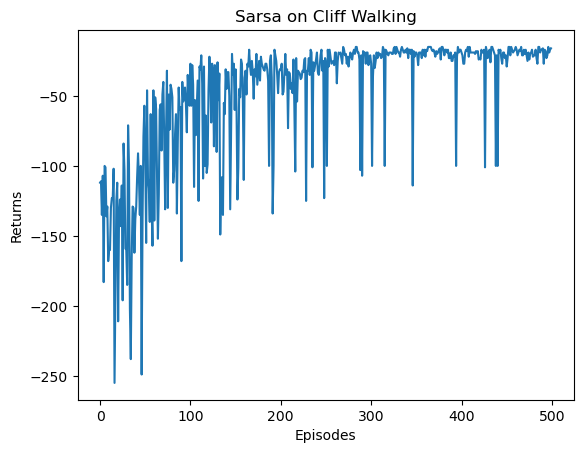

In [20]:
# 可视化return的情况
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list,return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()

In [24]:
# 打印策略
action_meaning = ['^', 'v', '<', '>']
end = [nrow * ncol -1]
disaster_s = (nrow-1) * ncol + 1
disaster_e = nrow*ncol - 1
disaster = list(range(disaster_s,disaster_e))
print('Sarsa算法最终收敛得到的策略为：')
print_agent(agent,env,action_meaning,disaster,end)

Sarsa算法最终收敛得到的策略为：
ooo>ooo>ooo>ooo>ooo>ooo>ooo>ooo>ooo>ooo>ooo>ovoo
ooo>ooo>ooo>ooo>ooo>ooo>ooo>ooo>ooo>ooo>ooo>ovoo
^oooooo>^oooooo>ooo>ooo>ooo>^ooo^oooooo>ooo>ovoo
^ooo**** **** **** **** **** **** **** **** **** **** EEEE 


In [17]:
# N 步 SARSA实践
np.random.seed(0)
n_step = 5  # 5步Sarsa算法
alpha = 0.1
epsilon = 0.1
gamma = 0.9

ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol,nrow)
agent = nstep_Sarsa(n_step,ncol,nrow,epsilon,alpha,gamma,len(env.actions))
num_episodes = 500

In [18]:
return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10),desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False

            while not done:
                next_state,reward,done = env.step(action)
                next_action = agent.take_action(next_state)
                agent.update(state,action,reward,next_state,next_action,done)
                episode_return += reward

                state = next_state
                action = next_action
            
            return_list.append(episode_return)
            
            # 打印中间信息
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':'%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 4551.41it/s, episode=500, return=-19.100]


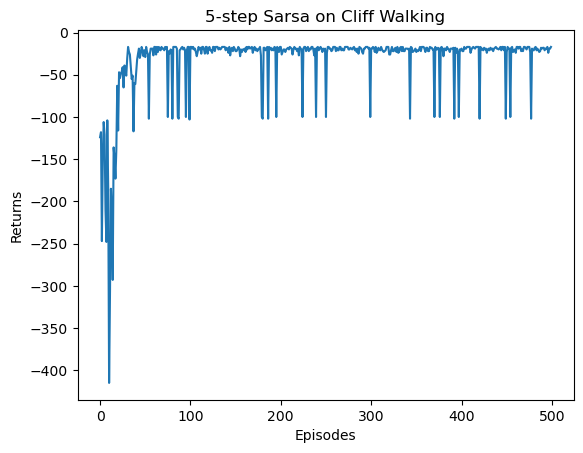

In [19]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('5-step Sarsa on {}'.format('Cliff Walking'))
plt.show()

In [22]:
action_meaning = ['^', 'v', '<', '>']
end = [nrow * ncol -1]
disaster_s = (nrow-1) * ncol + 1
disaster_e = nrow*ncol - 1
disaster = list(range(disaster_s,disaster_e))
print('5步Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, disaster, end)

5步Sarsa算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ^ooo ^ooo oo<o ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ovoo 
ooo> ^ooo ^ooo ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 
